# SpikeInterface DEMO v0.99 -  Cambridge Neurotech Webinar

## November 2023

For this demo we will use a small file provided by Eduarda Centeno, Arthur Leblois and Aude Retailleau from IMN lab in Bordeaux.

It is a recording from a zebra finch using the "ASSY-236-H5" probe from Cambridge Neurotech.
The acquisition system is the Open Ephys usb3 board.
This file is only for testing or teaching purposes.

The dataset can be download here
https://drive.google.com/drive/folders/17RlgsMLheW82IMLMgmTFifVACebDZ8X5?usp=sharing


# Table of contents

* [0. Preparation](#preparation)
* [1. Reading recording and sorting](#loading)
* [2. Preprocessing](#preprocessing)
* [3. Saving and loading SpikeInterface objects](#save-load)
* [4. Spike sorting](#spike-sorting)
* [5. Extracting waveforms](#waveforms)
* [6. Postprocessing](#postprocessing)
* [7. Validation and curation](#curation)
* [8. Viewers](#viewers)
* [9. Spike sorting comparison](#comparison)
* [10. Exporters](#exporters)

# 0. Preparation <a class="anchor" id="preparation"></a>

### Download the ephys data



In [1]:
import spikeinterface.full as si

c:\Users\neuroPC\anaconda3\envs\spike_interface\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(f"SpikeInterface version: {si.__version__}")

SpikeInterface version: 0.101.0


In [3]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import os

import warnings
warnings.simplefilter("ignore")

# %matplotlib widget
%matplotlib inline

# 1. Reading recording and sorting <a class="anchor" id="loading"></a>

More documention on this section here: https://spikeinterface.readthedocs.io/en/latest/modules/core.html

In [4]:
#base_folder = Path('/data_local/DataSpikeSorting/SI_tutorial_cambridgeneurotech_2023')
#base_folder = Path(r"C:\Users\neuroPC\Documents\Open Ephys")
base_folder = Path(r"Z:\DATA\experiment_openEphys\P-series-32channels")
#oe_folder = base_folder / "2024-04-09_15-57-39"
oe_folder = base_folder / "2024-04-22_01-09-50"

In [5]:
full_raw_rec = si.read_openephys(oe_folder)

The `read_openephys()` function returns a `Recording` (or `RecordingExtractor`) object. We can print it to visualize some of its properties:

In [107]:
full_raw_rec

OpenEphysBinaryRecordingExtractor: 40 channels - 30.0kHz - 1 segments - 320,098,754 samples 
                                   10,669.96s (2.96 hours) - int16 dtype - 23.85 GiB

Our recording is 64 ephys channels and 8 auxs

In [7]:
full_raw_rec.channel_ids

array(['CH1', 'CH2', 'CH3', 'CH4', 'CH5', 'CH6', 'CH7', 'CH8', 'CH9',
       'CH10', 'CH11', 'CH12', 'CH13', 'CH14', 'CH15', 'CH16', 'CH17',
       'CH18', 'CH19', 'CH20', 'CH21', 'CH22', 'CH23', 'CH24', 'CH25',
       'CH26', 'CH27', 'CH28', 'CH29', 'CH30', 'CH31', 'CH32', 'ADC1',
       'ADC2', 'ADC3', 'ADC4', 'ADC5', 'ADC6', 'ADC7', 'ADC8'],
      dtype='<U64')

`spikeinterface.extractors` integrate many readers

In [8]:
si.recording_extractor_full_dict

{'binaryfolder': spikeinterface.core.binaryfolder.BinaryFolderRecording,
 'binary': spikeinterface.core.binaryrecordingextractor.BinaryRecordingExtractor,
 'zarr': spikeinterface.core.zarrextractors.ZarrRecordingExtractor,
 'numpy': spikeinterface.core.numpyextractors.NumpyRecording,
 'shybrid': spikeinterface.extractors.shybridextractors.SHYBRIDRecordingExtractor,
 'mda': spikeinterface.extractors.mdaextractors.MdaRecordingExtractor,
 'nwb': spikeinterface.extractors.nwbextractors.NwbRecordingExtractor,
 'cbin_ibl': spikeinterface.extractors.cbin_ibl.CompressedBinaryIblExtractor,
 'ibl_streaming_recording': spikeinterface.extractors.iblstreamingrecording.IblStreamingRecordingExtractor,
 'mcsh5': spikeinterface.extractors.mcsh5extractors.MCSH5RecordingExtractor,
 'alphaomega': spikeinterface.extractors.neoextractors.alphaomega.AlphaOmegaRecordingExtractor,
 'axona': spikeinterface.extractors.neoextractors.axona.AxonaRecordingExtractor,
 'biocam': spikeinterface.extractors.neoextractors

A `Recording` object extracts information about channel ids, channel locations (if present), the sampling frequency of the recording, and the extracellular traces (when prompted).

The `OpenEphysBinaryRecording` is designed specifically for open ephys format.

Same idea for all of then, the `NwbRecording` is designed specifically for NWB files....

Here we retrieve information from the recording using the built-in functions from the `Recording`:

SpikeInterface supports multi-segment recordings. A segment is a contiguous piece of data, and sometimes recordings can be made of multiple acquisitions, for examples a baseline, a stimulation phase, and a post recording. In such cases, the recording object will be made of multiple segments and be treated as such over the pipeline.

The `get_traces()` function returns a TxN numpy array where N is the number of channel ids passed in (all channel ids are passed in by default) and T is the number of frames (determined by start_frame and end_frame).

In [6]:
fs = full_raw_rec.get_sampling_frequency()
trace_snippet = full_raw_rec.get_traces(start_frame=int(fs*0), end_frame=int(fs*2))

In [7]:
print('Traces shape:', trace_snippet.shape)

Traces shape: (60000, 40)


Before moving on with the analysis, we have to load the probe information. For this we will use the [ProbeInterface](https://probeinterface.readthedocs.io/en/main/index.html) package. 

ProbeInterface allows to easily create, manipulate, and visualize neural probes. Moreover, it comes with a wide range of IO functions to import and export existing formats. Finally, we have created a public library of commercial probes (https://github.com/SpikeInterface/probeinterface_library) that can be retrieved with a single line of code.

Let's import `probeinterface`, download the probe and plot it!

In [4]:
import probeinterface as pi
from probeinterface.plotting import plot_probe

In [ ]:
manufacturer = 'cambridgeneurotech'
probe_name = 'ASSY-77-H10'

probe = pi.get_probe(manufacturer, probe_name)
print(probe)

Probe - cambridgeneurotech - ASSY-77-H10 - 64ch - 2shanks


In [6]:
manufacturer = 'cambridgeneurotech'
probe_name = 'ASSY-37-P-2'

probe = pi.get_probe(manufacturer, probe_name)
print(probe)

ASSY-37-P-2 - cambridgeneurotech - 32ch - 2shanks


In most experiments, the neural probe has a connector, that is interfaced to an headstage, which in turn connects to the acquisition system. This *pathway* usually results in a channel remapping, which means that the order of the contacts on the probe is different than the order of the recorded traces.

`probeinterface` provides a growing collection of common pathways that can be loaded directly to wire a device and apply the correct channel mapping:

In [8]:
pi.get_available_pathways()

['H32>RHD2132',
 'ASSY-156>RHD2164',
 'ASSY-116>RHD2132',
 'ASSY-77>Adpt.A64-Om32_2x-sm-NN>RHD2164',
 'ASSY-77>Adpt.A64-Om32_2x-sm-NN>two_RHD2132',
 'cambridgeneurotech_mini-amp-64']

In [10]:
probe.wiring_to_device('ASSY-116>RHD2132')

In [14]:
# 'ASSY-77>Adpt.A64-Om32_2x-sm-NN>RHD2164',
# 'ASSY-77>Adpt.A64-Om32_2x-sm-NN>two_RHD2132'
probe.wiring_to_device('ASSY-77>Adpt.A64-Om32_2x-sm-NN>two_RHD2132')

In [ ]:
mirror_mapping=[]##Here to input the new mapping from 1 to 64
probe.set_device_channel_indices(mirror_mapping)

In [ ]:
##Here to input the mapping of the second probe. THis is necessary for stacked probe. Presumably, the second probe will have the channel number starting from 65
#And the shank number will be 2
#probe.set_device_channel_indices(mirror_mapping, shank=2)

(-100.0, 500.0)

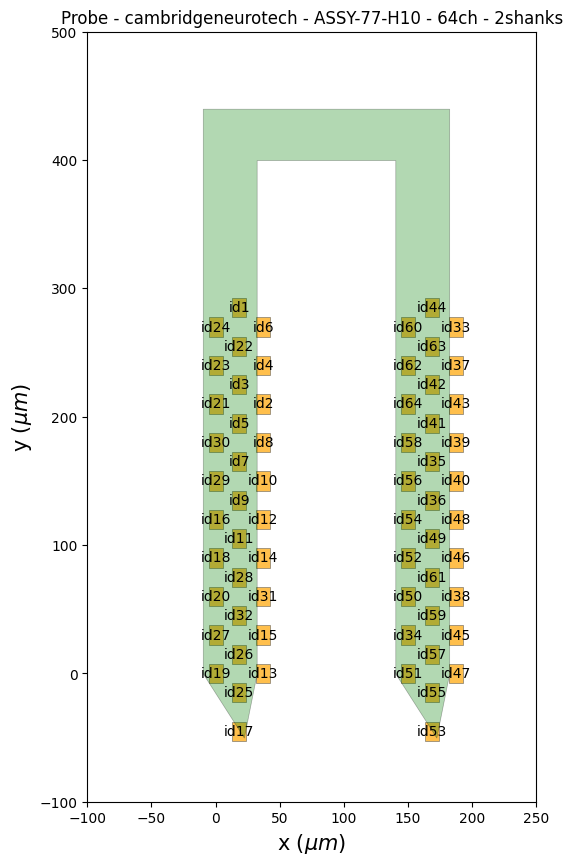

In [19]:
fig, ax = plt.subplots(figsize=(14, 10))
plot_probe(probe, ax=ax,with_contact_id=True, with_device_index=False,)
ax.set_xlim(-100, 250)
ax.set_ylim(-100, 500)

In [17]:
probe.to_dataframe(complete=True).loc[:, ["contact_ids", "shank_ids", "device_channel_indices"]]

,contact_ids,shank_ids,device_channel_indices
0,1,0,47
1,2,0,32
2,3,0,46
3,4,0,33
4,5,0,34
...,...,...,...
59,60,1,61
60,61,1,62
61,62,1,49
62,63,1,63


In [18]:
probe.to_dataframe(complete=True)

,x,y,contact_shapes,width,height,shank_ids,contact_ids,device_channel_indices,si_units,plane_axis_x_0,plane_axis_x_1,plane_axis_y_0,plane_axis_y_1
0,18.5,285.0,rect,11.0,15.0,0,1,47,um,1.0,0.0,0.0,1.0
1,37.0,210.0,rect,11.0,15.0,0,2,32,um,1.0,0.0,0.0,1.0
2,18.5,225.0,rect,11.0,15.0,0,3,46,um,1.0,0.0,0.0,1.0
3,37.0,240.0,rect,11.0,15.0,0,4,33,um,1.0,0.0,0.0,1.0
4,18.5,195.0,rect,11.0,15.0,0,5,34,um,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,150.0,270.0,rect,11.0,15.0,1,60,61,um,1.0,0.0,0.0,1.0
60,168.5,75.0,rect,11.0,15.0,1,61,62,um,1.0,0.0,0.0,1.0
61,150.0,240.0,rect,11.0,15.0,1,62,49,um,1.0,0.0,0.0,1.0
62,168.5,255.0,rect,11.0,15.0,1,63,63,um,1.0,0.0,0.0,1.0


(-50.0, 300.0)

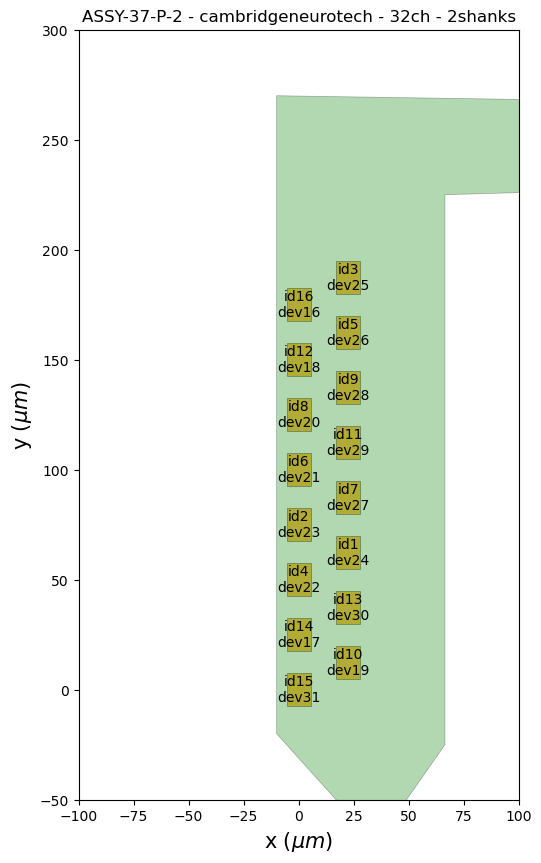

In [12]:
fig, ax = plt.subplots(figsize=(14, 10))
plot_probe(probe, ax=ax, with_contact_id=True, with_device_index=True,)
ax.set_xlim(-100, 100)
ax.set_ylim(-50, 300)

The probe now has contact ids `id#` and device ids `dev#`! We can also visualize the probe information as a `pandas` dataframe:

In [13]:
probe.to_dataframe(complete=True).loc[:, ["contact_ids", "shank_ids", "device_channel_indices"]]

,contact_ids,shank_ids,device_channel_indices
0,1,0,24
1,2,0,23
2,3,0,25
3,4,0,22
4,5,0,26
5,6,0,21
6,7,0,27
7,8,0,20
8,9,0,28
9,10,0,19


When loading the probe, the device indices (and all the other contact properties) are automatically sorted.
And very importantly the recording is reduce to 644 channels!

In [14]:
raw_rec = full_raw_rec.set_probe(probe)
raw_rec

ChannelSliceRecording: 32 channels - 30.0kHz - 1 segments - 112,505,620 samples 
                       3,750.19s (1.04 hours) - int16 dtype - 6.71 GiB

In [15]:
probe_rec = raw_rec.get_probe()
probe_rec.to_dataframe(complete=True).loc[:, ["contact_ids", "device_channel_indices"]]

,contact_ids,device_channel_indices
0,17,0
1,19,1
2,21,2
3,23,3
4,25,4
5,27,5
6,29,6
7,31,7
8,32,8
9,30,9


We can now visualize the channel_id (channel name) from open ephys.

(-50.0, 300.0)

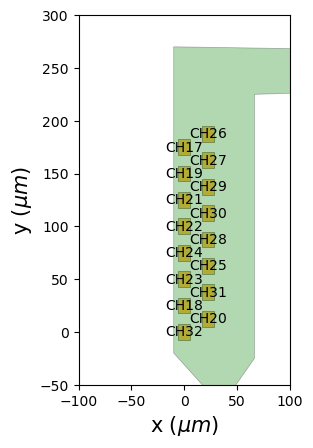

In [16]:
fig, ax = plt.subplots()
si.plot_probe_map(raw_rec, with_channel_ids=True, ax=ax)
ax.set_xlim(-100, 100)
ax.set_ylim(-50, 300)

The `widgets` module includes several convenient plotting functions that can be used to explore the data:

In [17]:
%matplotlib widget
si.plot_traces(raw_rec, backend="ipywidgets", mode='line', channel_ids=raw_rec.channel_ids[::8])

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

In [15]:
spike_times=np.load(r'C:\Users\neuroPC\Documents\GitHub\ephys\spike_times.npy')
print(spike_times)

[ 899.39823333  905.2924      939.99943333 1768.5384     1768.53843333
 1768.58803333 1768.58806667 1768.62266667 1768.62273333 1774.5293
 1774.52936667 1775.74433333 1782.33903333 1782.38936667 1782.3894
 1782.4394     1784.83226667 2352.9488     2352.94883333 2353.01566667
 2353.0157     2353.05386667 2353.05393333 2354.1045     2354.10453333
 2356.224      2356.22403333 2357.15576667 2357.1558     2357.84336667
 2357.8434     2359.95096667 2359.951      2360.03903333 2360.03906667
 2362.1336     2362.13363333 2362.9228     2362.92283333 2362.99373333
 2362.9938     2364.81726667 2364.81733333 2364.8622     2366.1878
 2366.18783333 2374.37106667 2374.3711     2376.08773333 2376.1821
 2376.18216667 2376.85653333 2376.85656667 2377.88953333 2377.88956667
 2382.41283333 2383.4225     2383.42253333 2383.65033333 2383.65033333
 2385.05656667 2385.05656667 2809.4956     2809.4956     2809.52473333
 2809.52476667 2809.56486667 2809.56493333 2817.9739     2817.97393333
 2819.34496667 2819.34

### Properties 

`Recording` objects can have *properties*. A property is a piece of information attached to a channel, e.g. group or location.

Similarly, for `Sorting` objects (that we'll cover later), anything related to a unit can be stored as a property. 

We can check which properties are in the extractor as follows:

In [22]:
print("Properties:\n", list(raw_rec.get_property_keys()))

Properties:
 ['gain_to_uV', 'offset_to_uV', 'channel_name', 'contact_vector', 'location', 'group']


Let's add some new properties! 
The first 192 channels are in the CA1 area, the second 192 are in the CA3 area:

In [23]:
#brain_area_property_values = ['CA1']*32 + ['CA3']*32
#print(brain_area_property_values)

In [24]:
#raw_rec.set_property(key='brain_area', values=brain_area_property_values)

In [25]:
#raw_rec.get_property_keys()

In [26]:
#raw_rec.get_property("brain_area")

**NOTE:** Internally the properties is jus a dictionary attached to the recording that is accessible as `_properties`

### Annotations

*Annotations* can be attached to any object and they can carry any information related to the recording or sorting objects.

Let's add an annotation about this tutorial:

In [18]:
raw_rec.annotate(description="Dataset for Testing SI")

In [19]:
print(raw_rec.get_annotation_keys())

['is_filtered', 'probe_0_planar_contour', 'description']


# 2. Preprocessing <a class="anchor" id="preprocessing"></a>

Now that the probe information is loaded we can do some preprocessing using `preprocessing` module.

We can filter the recordings, rereference the signals to remove noise, discard noisy channels, whiten the data, remove stimulation artifacts, etc. 

For this notebook, let's filter the recordings and apply common median reference (CMR). All preprocessing modules return new `Recording` objects that apply the underlying preprocessing function. This allows users to access the preprocessed data in the same way as the raw data.

More documention on this section here: https://spikeinterface.readthedocs.io/en/latest/modules/preprocessing.html


Below, we bandpass filter the recording and apply common median reference to the original recording:

In [20]:
recording_f = si.bandpass_filter(raw_rec, freq_min=300, freq_max=6000)

Let's now apply Common Median Reference (CMR):

In [21]:
recording_cmr = si.common_reference(recording_f, reference='global', operator='median')

We can plot the traces after applying CMR:

In [22]:
%matplotlib widget
w = si.plot_traces({"filtered": recording_f, "common": recording_cmr}, mode='map',
                   time_range=[10, 10.1], backend="ipywidgets")

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

## Removing bad channels



In [28]:
bad_channel_ids, channel_labels = si.detect_bad_channels(recording_f, method='coherence+psd')
print('bad_channel_ids', bad_channel_ids)
print('channel_labels', channel_labels)

bad_channel_ids ['CH3' 'CH4' 'CH5' 'CH6' 'CH10' 'CH12' 'CH13' 'CH15' 'CH16' 'CH17' 'CH23'
 'CH26' 'CH31']
channel_labels ['good' 'good' 'noise' 'noise' 'noise' 'noise' 'good' 'good' 'good'
 'noise' 'good' 'noise' 'noise' 'good' 'noise' 'noise' 'dead' 'good'
 'good' 'good' 'good' 'good' 'dead' 'good' 'good' 'dead' 'good' 'good'
 'good' 'good' 'dead' 'good']


In [29]:
recording_good_channels_f = recording_f.remove_channels(bad_channel_ids)
recording_good_channels = si.common_reference(recording_good_channels_f, reference='global', operator='median')

print(recording_good_channels)
print(recording_good_channels.channel_ids)

CommonReferenceRecording: 19 channels - 30.0kHz - 1 segments - 116,448,180 samples 
                          3,881.61s (1.08 hours) - int16 dtype - 4.12 GiB
['CH1' 'CH2' 'CH7' 'CH8' 'CH9' 'CH11' 'CH14' 'CH18' 'CH19' 'CH20' 'CH21'
 'CH22' 'CH24' 'CH25' 'CH27' 'CH28' 'CH29' 'CH30' 'CH32']


In [34]:
recording_good_channels

CommonReferenceRecording: 19 channels - 30.0kHz - 1 segments - 116,448,180 samples 
                          3,881.61s (1.08 hours) - int16 dtype - 4.12 GiB

In [30]:
w = si.plot_traces(recording_good_channels, mode='map',
                   time_range=[10, 10.1],
                   backend="ipywidgets")

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

**NOTE**: you can also set a default plotting backend with the `si.set_default_plotter_backend()` function.

## Take only 5 min. for demo

Since we are going to spike sort the data, let's first cut out a 5-minute recording, to speed up computations. 
In this case, the raw data is already 5 minutes, but this can be useful to test on other longer datasets.

We can easily do so with the `frame_slice()` function:

In [110]:
fs = recording_cmr.get_sampling_frequency()
start_sec=1
end_sec=1000
using_full_channels=False
if using_full_channels==True:
    recording_sub = recording_f.frame_slice(start_frame=start_sec*fs, end_frame=end_sec*fs)
else:
    recording_sub = recording_good_channels.frame_slice(start_frame=start_sec*fs, end_frame=end_sec*fs)
recording_sub

FrameSliceRecording: 32 channels - 30.0kHz - 1 segments - 29,970,000 samples 
                     999.00s (16.65 minutes) - int16 dtype - 1.79 GiB

In [31]:
raw_rec_sub = raw_rec.frame_slice(start_frame=start_sec*fs, end_frame=end_sec*fs)
raw_rec_sub

FrameSliceRecording: 32 channels - 30.0kHz - 1 segments - 17,970,000 samples 
                     599.00s (9.98 minutes) - int16 dtype - 1.07 GiB

# 3. Saving and loading SpikeInterface objects <a class="anchor" id="save-load"></a>

All operations in SpikeInterface are *lazy*, meaning that they are not performed if not needed. This is why the creation of our filter recording was almost instantaneous. However, to speed up further processing, we might want to **save** it to a file and perform those operations (eg. filters, CMR, etc.) at once. 

In [31]:
n_cpus = os.cpu_count()
n_jobs = n_cpus - 4

In [32]:
job_kwargs = dict(n_jobs=n_jobs, chunk_duration="1s", progress_bar=True)

In [33]:
base_folder

WindowsPath('C:/Users/neuroPC/Documents/Open Ephys')

In [35]:
recording_saved = recording_good_channels.save(folder=oe_folder / "preprocessed",overwrite=True,**job_kwargs)

write_binary_recording with n_jobs = 8 and chunk_size = 30000


write_binary_recording:   0%|          | 0/3882 [00:00<?, ?it/s]

**Note**: you can use the `si.set_global_job_kwargs()` to set `job_kwargs` globally for the entire session!

In [111]:
if (oe_folder / "preprocessed").is_dir():
    recording_saved = si.load_extractor(oe_folder / "preprocessed")
else:
    recording_saved = recording_sub.save(folder=oe_folder / "preprocessed", **job_kwargs)

If we inspect the `preprocessed` folder, we find that a few files have been saved. Let's take a look at what they are:

In [112]:
recording_saved

BinaryFolderRecording: 32 channels - 30.0kHz - 1 segments - 8,970,000 samples 
                       299.00s (4.98 minutes) - int16 dtype - 547.49 MiB

In [42]:
!ls -llh {oe_folder}/preprocessed

'ls' is not recognized as an internal or external command,
operable program or batch file.


The `traces_cached_seg0.raw` contains the processed raw data, while the `.json` files include information on how to reload the binary file. The `provenance.json` includes the information of the recording before saving it to a binary file, and the `probe.json` represents the probe object. 

The `save` returns a new *cached* recording that has all the previously loaded information:

In [36]:
print(f'Saved channels ids:\n{recording_saved.get_channel_ids()}')

Saved channels ids:
['CH1' 'CH2' 'CH3' 'CH4' 'CH5' 'CH6' 'CH7' 'CH8' 'CH9' 'CH10' 'CH11'
 'CH12' 'CH13' 'CH14' 'CH15' 'CH16' 'CH17' 'CH18' 'CH19' 'CH20' 'CH21'
 'CH22' 'CH23' 'CH24' 'CH25' 'CH26' 'CH27' 'CH28' 'CH29' 'CH30' 'CH31'
 'CH32']


After saving the SI object, we can easily load it back in a new session:

In [37]:
recording_loaded = si.load_extractor(oe_folder / "preprocessed")

In [38]:
print(f'Loaded channels ids:\n{recording_loaded.get_channel_ids()}')

Loaded channels ids:
['CH1' 'CH2' 'CH3' 'CH4' 'CH5' 'CH6' 'CH7' 'CH8' 'CH9' 'CH10' 'CH11'
 'CH12' 'CH13' 'CH14' 'CH15' 'CH16' 'CH17' 'CH18' 'CH19' 'CH20' 'CH21'
 'CH22' 'CH23' 'CH24' 'CH25' 'CH26' 'CH27' 'CH28' 'CH29' 'CH30' 'CH31'
 'CH32']


**IMPORTANT**:
The same saving mechanisms are available also for all `Sorting` objects,


## Data compression


SpikeInterface also offers a powerful compression framework based on [Zarr](https://zarr.readthedocs.io/en/stable/).

You can use the `save()` function to compress to `Zarr` with any available compressor (see [numcodecs](https://numcodecs.readthedocs.io/en/stable/) library).

In [36]:
import numcodecs

In [38]:
#overwrite existing savings
compressor = numcodecs.Blosc(cname="zstd", clevel=9, shuffle=numcodecs.Blosc.BITSHUFFLE)
recording_saved = recording_good_channels.save(format="zarr", folder=oe_folder / "preprocessed_compressed.zarr",
                                        compressor=compressor,overwrite=True,
                                        **job_kwargs)

write_zarr_recording with n_jobs = 8 and chunk_size = 30000


write_zarr_recording:   0%|          | 0/3882 [00:00<?, ?it/s]

In [21]:
if (oe_folder / "preprocessed_compressed.zarr").is_dir():
    recording_saved = si.read_zarr(oe_folder / "preprocessed_compressed.zarr")
else:
    import numcodecs
    compressor = numcodecs.Blosc(cname="zstd", clevel=9, shuffle=numcodecs.Blosc.BITSHUFFLE)
    recording_saved = recording_sub.save(format="zarr", folder=oe_folder / "preprocessed_compressed.zarr",
                                         compressor=compressor,
                                         **job_kwargs)

In [43]:
recording_saved

ZarrRecordingExtractor: 19 channels - 30.0kHz - 1 segments - 116,448,180 samples 
                        3,881.61s (1.08 hours) - int16 dtype - 4.12 GiB

In [53]:
!du -sh {base_folder}/preprocessed_compressed.zarr
!du -sh {base_folder}/preprocessed

388M	/data_local/DataSpikeSorting/SI_tutorial_cambridgeneurotech_2023/preprocessed_compressed.zarr
808M	/data_local/DataSpikeSorting/SI_tutorial_cambridgeneurotech_2023/preprocessed


For more details and an exhaustive comparison of compression methods, see our recent paper here:
https://doi.org/10.1088/1741-2552/acf5a4

# 4. Spike sorting <a class="anchor" id="spike-sorting"></a>

We can now run spike sorting on the above recording. We will use different spike sorters for this demonstration, to show how easy SpikeInterface makes it easy to interchengably run different sorters :)

Let's first check the available and installed sorters in `SpikeInterface`.
We will sort the bandpass cached filtered recording the `recording_saved` object.



More documention on this section here: https://spikeinterface.readthedocs.io/en/latest/modules/sorters.html

In [39]:
si.available_sorters()

['combinato',
 'hdsort',
 'herdingspikes',
 'ironclust',
 'kilosort',
 'kilosort2',
 'kilosort2_5',
 'kilosort3',
 'kilosort4',
 'klusta',
 'mountainsort4',
 'mountainsort5',
 'pykilosort',
 'spykingcircus',
 'spykingcircus2',
 'tridesclous',
 'tridesclous2',
 'waveclus',
 'waveclus_snippets',
 'yass']

In [40]:
si.installed_sorters()

['kilosort4', 'spykingcircus2', 'tridesclous2']

The `spikeinterface.sortingcomponents` module includes functions that can be used to create custom spike sorting pipelines built-in in `SpikeInterface`. It is still experimental and under heavy development, but there are already two SI-based sorters available:

* `tridesclous2` (developed by Samuel Garcia)
* `spykingcircus2` (developed by Pierre Yger)

They can be run with the same `run_sorter` function, but they don't require any additional installation!

For matlab based sorter we need to set the path of the source code

In [41]:
#kilosort_25_path = '/home/samuel.garcia/Documents/SpikeInterface/code_sorters/Kilosort2.5/'
#kilosort_3_path = r'C:\Users\neuroPC\Documents\GitHub\Kilosort'
kilosort_3_path = r'C:\Users\neuroPC\Documents\GitHub\Kilosort-3.0.2'
si.Kilosort3Sorter.set_kilosort3_path(kilosort_3_path)

Setting KILOSORT3_PATH environment variable for subprocess calls to: C:\Users\neuroPC\Documents\GitHub\Kilosort-3.0.2


In [42]:
si.installed_sorters()

['kilosort3', 'kilosort4', 'spykingcircus2', 'tridesclous2']

In [45]:
sorter_params=si.get_default_sorter_params('kilosort3')

In [57]:
si.Kilosort2_5Sorter.set_kilosort2_5_path(kilosort_25_path)
si.installed_sorters()

Setting KILOSORT2_5_PATH environment variable for subprocess calls to: /home/samuel.garcia/Documents/SpikeInterface/code_sorters/Kilosort2.5


['kilosort2_5',
 'mountainsort5',
 'spykingcircus2',
 'tridesclous',
 'tridesclous2']

We can retrieve the parameters associated to any sorter with the `get_default_params()` function from the `sorters` module:

In [77]:
si.get_default_sorter_params('kilosort4')

{'batch_size': 60000,
 'nblocks': 1,
 'Th_universal': 9,
 'Th_learned': 8,
 'do_CAR': True,
 'invert_sign': False,
 'nt': 61,
 'artifact_threshold': None,
 'nskip': 25,
 'whitening_range': 32,
 'binning_depth': 5,
 'sig_interp': 20,
 'nt0min': None,
 'dmin': None,
 'dminx': None,
 'min_template_size': 10,
 'template_sizes': 5,
 'nearest_chans': 10,
 'nearest_templates': 100,
 'templates_from_data': True,
 'n_templates': 6,
 'n_pcs': 6,
 'Th_single_ch': 6,
 'acg_threshold': 0.2,
 'ccg_threshold': 0.25,
 'cluster_downsampling': 20,
 'cluster_pcs': 64,
 'duplicate_spike_bins': 15,
 'do_correction': True,
 'keep_good_only': False,
 'save_extra_kwargs': False,
 'skip_kilosort_preprocessing': False,
 'scaleproc': None}

In [59]:
si.run_sorter?

Signature:
si.run_sorter(
    sorter_name: str,
    recording: spikeinterface.core.baserecording.BaseRecording,
    output_folder: Optional[str] = None,
    remove_existing_folder: bool = False,
    delete_output_folder: bool = False,
    verbose: bool = False,
    raise_error: bool = True,
    docker_image: Union[bool, str, NoneType] = False,
    singularity_image: Union[bool, str, NoneType] = False,
    delete_container_files: bool = True,
    with_output: bool = True,
    **sorter_params,
)
Docstring:
Generic function to run a sorter via function approach.


Parameters
----------
sorter_name: str
    The sorter name
recording: RecordingExtractor
    The recording extractor to be spike sorted
output_folder: str or Path
    Path to output folder
remove_existing_folder: bool
    If True and output_folder exists yet then delete.
delete_output_folder: bool, default: False
    If True, output folder is deleted
verbose: bool, default: False
    If True, output is verbose
raise_error: bool,

To modify a parameter, we can easily pass it to the `run` function as an extra argument!

### Run sorter locally

In [81]:
sorter_params = {'dminx': 250,'nearest_templates': 10}

In [104]:
recording_saved

ZarrRecordingExtractor: 32 channels - 30.0kHz - 1 segments - 8,970,000 samples 
                        299.00s (4.98 minutes) - int16 dtype - 547.49 MiB

In [26]:
sorter_params

{'do_correction': False}

In [50]:
# run spike sorting on entire recording
sorting_SC2 = si.run_sorter(sorter_name='spykingcircus2', recording=recording_cmr, remove_existing_folder=True,
                             output_folder=oe_folder / 'results_SC2',
                             verbose=True,job_kwargs=job_kwargs)

Error running spykingcircus2


SpikeSortingError: Spike sorting error trace:
Traceback (most recent call last):
  File "c:\Users\neuroPC\anaconda3\envs\ephys\Lib\site-packages\spikeinterface\sorters\basesorter.py", line 258, in run_from_folder
    SorterClass._run_from_folder(sorter_output_folder, sorter_params, verbose)
  File "c:\Users\neuroPC\anaconda3\envs\ephys\Lib\site-packages\spikeinterface\sorters\internal\spyking_circus2.py", line 89, in _run_from_folder
    assert HAVE_HDBSCAN, "spykingcircus2 needs hdbscan to be installed"
AssertionError: spykingcircus2 needs hdbscan to be installed

Spike sorting failed. You can inspect the runtime trace in C:\Users\neuroPC\Documents\Open Ephys\2024-02-01_15-25-25\results_SC2/spikeinterface_log.json.

In [113]:
# run spike sorting on entire recording
sorting_KS4 = si.run_sorter(sorter_name='kilosort4', recording=recording_sub, remove_existing_folder=True,
                             output_folder=oe_folder / 'results_KS4',
                             verbose=True, **sorter_params)

Loading recording with SpikeInterface...
number of samples: 29970000
number of channels: 32
numbef of segments: 1
sampling rate: 30000.0
dtype: int16
Preprocessing filters computed in  1.98s; total  1.98s

computing drift
Re-computing universal templates from data.


100%|██████████| 500/500 [00:58<00:00,  8.59it/s]


drift computed in  59.91s; total  61.89s

Extracting spikes using templates
Re-computing universal templates from data.


100%|██████████| 500/500 [00:57<00:00,  8.62it/s]


28157 spikes extracted in  59.47s; total  121.36s

First clustering


100%|██████████| 8/8 [00:02<00:00,  2.88it/s] 


18 clusters found, in  2.80s; total  124.16s

Extracting spikes using cluster waveforms


100%|██████████| 500/500 [00:47<00:00, 10.52it/s]


53894 spikes extracted in  47.57s; total  171.73s

Final clustering


100%|██████████| 8/8 [00:01<00:00,  4.45it/s] 


8 clusters found, in  1.80s; total  173.53s

Merging clusters
8 units found, in  0.01s; total  173.54s

Saving to phy and computing refractory periods
1 units found with good refractory periods

Total runtime: 173.57s = 00:02:53 h:m:s
kilosort4 run time 173.80s


In [49]:
# run spike sorting on entire recording
sorting_KS3 = si.run_sorter(sorter_name='kilosort3', recording=recording_cmr, remove_existing_folder=True,
                             output_folder=oe_folder / 'results_KS3',
                             verbose=True,**sorter_params)

write_binary_recording:   0%|          | 0/3882 [00:00<?, ?it/s]

RUNNING SHELL SCRIPT: C:\Users\neuroPC\Documents\Open Ephys\2024-02-01_15-25-25\results_KS3\sorter_output\run_kilosort3.bat


(ephys) c:\Users\neuroPC\Documents\GitHub\spiketutorials\Official_Tutorial_SI_0.99_Nov23>C:



(ephys) c:\Users\neuroPC\Documents\GitHub\spiketutorials\Official_Tutorial_SI_0.99_Nov23>cd C:\Users\neuroPC\Documents\Open Ephys\2024-02-01_15-25-25\results_KS3\sorter_output 



(ephys) C:\Users\neuroPC\Documents\Open Ephys\2024-02-01_15-25-25\results_KS3\sorter_output>matlab -nosplash -wait -r "kilosort3_master('C:\Users\neuroPC\Documents\Open Ephys\2024-02-01_15-25-25\results_KS3\sorter_output', 'C:\Users\neuroPC\Documents\GitHub\Kilosort-3.0.2')" 

Error running kilosort3


SpikeSortingError: Spike sorting error trace:
Traceback (most recent call last):
  File "c:\Users\neuroPC\anaconda3\envs\ephys\Lib\site-packages\spikeinterface\sorters\basesorter.py", line 258, in run_from_folder
    SorterClass._run_from_folder(sorter_output_folder, sorter_params, verbose)
  File "c:\Users\neuroPC\anaconda3\envs\ephys\Lib\site-packages\spikeinterface\sorters\external\kilosortbase.py", line 217, in _run_from_folder
    raise Exception(f"{cls.sorter_name} returned a non-zero exit code")
Exception: kilosort3 returned a non-zero exit code

Spike sorting failed. You can inspect the runtime trace in C:\Users\neuroPC\Documents\Open Ephys\2024-02-01_15-25-25\results_KS3/spikeinterface_log.json.

In [19]:
sorting_KS3 = si.run_sorter(sorter_name='kilosort3', recording=recording_saved, remove_existing_folder=True,
                             output_folder=oe_folder / 'results_KS3',
                             verbose=True,docker_image=True,**job_kwargs)

installation_mode='auto' switching to installation_mode: 'github'


DockerException: Error while fetching server API version: (2, 'CreateFile', 'The system cannot find the file specified.')

In [15]:
sorter_params = {'do_correction': False}

We can check the output object:

In [45]:
sorting_KS3

KiloSortSortingExtractor: 20 units - 1 segments - 30.0kHz

SpikeInterface ensures full provenance of the spike sorting pipeline. Upon running a spike sorter, a `spikeinterface_params.json` file is saved in the `output_folder`. This contains a `.json` version of the recording and all the input parameters. 

In [63]:
!ls -llh {base_folder}/results_KS25

total 20K
drwxrwx--- 2 samuel.garcia crnl 4,0K nov.   7 14:55 sorter_output
-rw-rw---- 1 samuel.garcia crnl 2,2K nov.   7 14:55 spikeinterface_log.json
-rw-rw---- 1 samuel.garcia crnl  943 nov.   7 14:54 spikeinterface_params.json
-rw-rw---- 1 samuel.garcia crnl 7,3K nov.   7 14:54 spikeinterface_recording.json


In [64]:
!cat {base_folder}/results_KS25/spikeinterface_params.json

{
    "sorter_name": "kilosort2_5",
    "sorter_params": {
        "detect_threshold": 6,
        "projection_threshold": [
            10,
            4
        ],
        "preclust_threshold": 8,
        "car": true,
        "minFR": 0.1,
        "minfr_goodchannels": 0.1,
        "nblocks": 5,
        "sig": 20,
        "freq_min": 150,
        "sigmaMask": 30,
        "nPCs": 3,
        "ntbuff": 64,
        "nfilt_factor": 4,
        "NT": 65600,
        "AUCsplit": 0.9,
        "do_correction": false,
        "wave_length": 61,
        "keep_good_only": false,
        "skip_kilosort_preprocessing": false,
        "scaleproc": null,
        "save_rez_to_mat": false,
        "delete_tmp_files": [
            "matlab_files"
        ],
        "delete_recording_dat": false,
        "n_jobs": 36,
        "chunk_duration": "1s",
        "progress_bar": true,
        "mp_context": null,
        "max_threads_per_process": 1
    }
}

The spike sorting returns a `Sorting` object. Let's see some of its functions:

In [46]:
print(f'Spike train of a unit: {sorting_KS3.get_unit_spike_train(unit_id=1)}')
print(f'Spike train of a unit (in s): {sorting_KS3.get_unit_spike_train(unit_id=1, return_times=True)}')

Spike train of a unit: [  208020   359161   455933  1040040  1055803  1163897  1185637  1321641
  1429611  1652226  1816941  1921400  1949413  1983404  2111265  2441805
  2448350  2449738  2528826  2561134  2927669  2938505  2952943  2997895
  3334157  3393196  3488749  3502783  3687523  3716385  3782601  3941443
  4023673  4103896  4217179  4326561  4477935  4483242  4713449  4788154
  4863643  4903138  4910340  4933036  4934814  4977508  5067106  5081714
  5102375  5266245  5308341  5315984  5632107  5717213  5782796  5809230
  5827454  5888141  6394803  6419492  6447888  6514965  6587770  6654610
  6741752  6898791  6988183  7411589  7454124  7689886  7690133  7706952
  7756971  8004171  8329536  8441076  8531031  8629545  8751044  8757083
  8799334  8852451  8995665  9002196  9479076  9952074 10321083 10340968
 10467540 10649029 10954147 11002702 11219317 11266551 11785027 11837694
 12333554 12463222 12466806 12505484 12716935 12964362 13002290 13009633
 13144859 13192645 13211043 

We can use `widgets` functions for some quick visualizations:

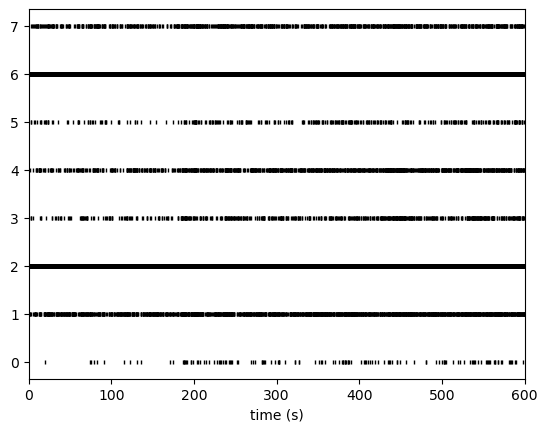

In [114]:
%matplotlib inline
w_rs = si.plot_rasters(sorting_KS4, time_range=(0, 600), backend="matplotlib")

We can also save a spike sorting output for future use:

In [116]:
sorting_saved_KS4 = sorting_KS4.save(folder=oe_folder / "sorting_KS4", overwrite=True)

PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\neuroPC\\Documents\\Open Ephys\\2024-02-01_18-55-51\\sorting_KS4\\spikes.npy'

In [29]:
sorting_KS3.save(folder=oe_folder / "sorting_KS3", overwrite=True)

NumpyFolderSorting: 60 units - 1 segments - 30.0kHz

In [49]:
sorting_loaded_KS3 = si.load_extractor(oe_folder / "sorting_KS3")

### Run sorter in container

Some sorters are hard to install! To alleviate this headache, SI provides a built-in mechanism to run a spike sorting job in a docker container.

We are maintaining a set of sorter-specific docker files in the [spikeinterface-dockerfiles repo](<https://github.com/SpikeInterface/spikeinterface-dockerfiles>)
and most of the docker images are available on Docker Hub from the [SpikeInterface organization](<https://hub.docker.com/orgs/spikeinterface/repositories>).

Running spike sorting in a docker container just requires to:

1. have docker/singularity installed
2. have docker/singularity python SDK installed (`pip install docker/spython`)

See this documentation : https://spikeinterface.readthedocs.io/en/latest/modules/sorters.html#running-sorters-in-docker-singularity-containers

When docker/singularity is installed, you can simply run the sorter in a container image:

In [70]:
sorting_KS2

KiloSortSortingExtractor: 151 units - 1 segments - 30.0kHz

In [71]:
print(f'KS2 found {len(sorting_KS2.get_unit_ids())} units')

KS2 found 151 units


### Run internal sorter : spykingcircus2

In [72]:
sorting_SC2 = si.run_sorter('spykingcircus2', recording_saved, 
                            output_folder=base_folder / 'results_SC2',
                            verbose=True, job_kwargs=job_kwargs)

detect peaks using locally_exclusive with n_jobs = 36 and chunk_size = 30000


detect peaks using locally_exclusive:   0%|          | 0/300 [00:00<?, ?it/s]

We found 97705 peaks in total
We kept 97705 peaks for clustering
extracting features with n_jobs = 36 and chunk_size = 30000


extracting features:   0%|          | 0/300 [00:00<?, ?it/s]

We found 69 raw clusters, starting to clean with matching...
extract waveforms shared_memory multi buffer with n_jobs = 36 and chunk_size = 30000


extract waveforms shared_memory multi buffer:   0%|          | 0/300 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer with n_jobs = 36 and chunk_size = 30000


extract waveforms shared_memory multi buffer:   0%|          | 0/300 [00:00<?, ?it/s]

We kept 57 non-duplicated clusters...
extract waveforms shared_memory multi buffer with n_jobs = 36 and chunk_size = 30000


extract waveforms shared_memory multi buffer:   0%|          | 0/300 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer with n_jobs = 36 and chunk_size = 30000


extract waveforms shared_memory multi buffer:   0%|          | 0/300 [00:00<?, ?it/s]

find spikes (circus-omp-svd) with n_jobs = 36 and chunk_size = 3000


find spikes (circus-omp-svd):   0%|          | 0/3000 [00:00<?, ?it/s]

We found 261495 spikes
spykingcircus2 run time 142.46s


In [75]:
sorting_SC2 = si.read_sorter_folder(oe_folder/"results_SC2")

In [76]:
sorting_SC2

NumpyFolderSorting: 57 units - 1 segments - 30.0kHz

# 5. Extracting waveforms <a class="anchor" id="waveforms"></a>

The core of postprocessing spike sorting results revolves around extracting waveforms from paired recording-sorting objects.

In the SI API, waveforms are extracted using the `WaveformExtractor` class in the `core` module.

The `WaveformExtractor` object has convenient functions to retrieve waveforms and templates.
Let's see how it works.

To extract the waveforms, we can run:

In [50]:
recording_saved = si.load_extractor(oe_folder / "preprocessed")
sorting = sorting_KS3

In [32]:
recording_saved.annotate(is_filtered=True)

In [30]:
sorting = sorting_KS3

In [33]:
we = si.extract_waveforms(recording_saved, sorting_KS3, folder=oe_folder / "KS3_waveforms_dense", 
                          sparse=False, overwrite=True, **job_kwargs)
print(we)

Setting 'return_scaled' to False


extract waveforms memmap multi buffer:   0%|          | 0/1800 [00:00<?, ?it/s]

WaveformExtractor: 32 channels - 60 units - 1 segments
  before:30 after:60 n_per_units:500


In [78]:
si.extract_waveforms?

Signature:
si.extract_waveforms(
    recording,
    sorting,
    folder=None,
    mode='folder',
    precompute_template=('average',),
    ms_before=1.0,
    ms_after=2.0,
    max_spikes_per_unit=500,
    overwrite=False,
    return_scaled=True,
    dtype=None,
    sparse=True,
    sparsity=None,
    sparsity_temp_folder=None,
    num_spikes_for_sparsity=100,
    unit_batch_size=200,
    allow_unfiltered=False,
    use_relative_path=False,
    seed=None,
    load_if_exists=None,
    **kwargs,
)
Docstring:
Extracts waveform on paired Recording-Sorting objects.
Waveforms can be persistent on disk (`mode`="folder") or in-memory (`mode`="memory").
By default, waveforms are extracted on a subset of the spikes (`max_spikes_per_unit`) and on all channels (dense).
If the `sparse` parameter is set to True, a sparsity is estimated using a small number of spikes
(`num_spikes_for_sparsity`) and waveforms are extracted and saved in sparse mode.


Parameters
----------
recording: Recording
    The r

In [117]:
we = si.extract_waveforms(recording_saved, sorting_KS4, folder=oe_folder / "KS4_waveforms_dense", 
                          sparse=False, overwrite=True, **job_kwargs)
print(we)

PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\neuroPC\\Documents\\Open Ephys\\2024-02-01_18-55-51\\KS4_waveforms_dense\\waveforms\\waveforms_0.npy'

Now all waveforms are computed and stored in the provided `waveforms` folder. We can now retrieve waveforms and templates easily:

In [87]:
waveforms0 = we.get_waveforms(unit_id=0)
print(f"Waveforms shape: {waveforms0.shape}")
template0 = we.get_template(unit_id=4)
print(f"Template shape: {template0.shape}")
all_templates = we.get_all_templates()
print(f"All templates shape: {all_templates.shape}")

Waveforms shape: (500, 90, 32)


AssertionError: 

For waveforms, the dimension is (num_spikes, num_samples, num_channels), while each template has dimension (num_samples, num_channels). Note that the number of spikes in this case is 500..we'll get back to it later!

The `WaveformExtractor` is also compatible with several `widgets` to visualize the spike sorting output:

We can also render interactive plots with the `ipywidgets` backend!

In [53]:
%matplotlib widget
w = si.plot_unit_templates(we,backend="ipywidgets")

AppLayout(children=(HBox(children=(Checkbox(value=False, description='same axis'), Checkbox(value=True, descri…

As we noticed before, the number of spikes for the waveforms is 500. Let's check the number of spikes for other waveforms:

In [35]:
for unit in sorting.get_unit_ids()[::10]:
    waveforms = we.get_waveforms(unit_id=unit)
    spiketrain = sorting.get_unit_spike_train(unit)
    print(f"Unit {unit} - num waveforms: {waveforms.shape[0]} - num spikes: {len(spiketrain)}")

Unit 1 - num waveforms: 437 - num spikes: 437
Unit 12 - num waveforms: 500 - num spikes: 16962
Unit 22 - num waveforms: 181 - num spikes: 181
Unit 32 - num waveforms: 124 - num spikes: 124
Unit 45 - num waveforms: 138 - num spikes: 138
Unit 57 - num waveforms: 500 - num spikes: 625


No units have more than 500 spikes! This is because by default, the `WaveformExtractor` extracts waveforms on a random subset of 500 spikes. To extract waveforms on all spikes, we could use the `max_spikes_per_unit` argument, but this would be crazy:

```
we_all = si.extract_waveforms(recording_saved, sorting, folder=base_folder / "waveforms_all", 
                              max_spikes_per_unit=None,
                              overwrite=True,
                              **job_kwargs)
```

Now waveforms have been extracted for all spikes! Let's move on to explore the postprocessing capabilities of the `postprocessing` module.

## Sparsity

Especially when working with silicon high-density probes, or when our probe has multiple groups (e.g. multi-shank, tetrodes), we don't care about waveform/templates on all channels.
In order to find a subset of channels for each unit, we can use the `compute_sparsity()` which give an object of sparsity per unit.

In [36]:
sparsity = si.compute_sparsity(we, method='radius', radius_um=100.0)
sparsity

ChannelSparsity - units: 60 - channels: 32 - density, P(x=1): 0.43

In [37]:
#  check the sparsity for some units
for unit_id in sorting.unit_ids[::30]:
    print(unit_id, list(sparsity.unit_id_to_channel_ids[unit_id]))

1 ['CH1', 'CH3', 'CH5', 'CH6', 'CH7', 'CH8', 'CH9', 'CH10', 'CH11', 'CH12', 'CH13', 'CH14', 'CH15']
32 ['CH1', 'CH3', 'CH5', 'CH6', 'CH7', 'CH8', 'CH9', 'CH10', 'CH11', 'CH12', 'CH13', 'CH14', 'CH15']


In [86]:
## lets use this sparsity object to extract waveforms again

In [87]:
we = si.extract_waveforms(recording_saved, sorting, folder=base_folder / "waveforms_sparse_explicit", 
                          sparsity=sparsity, **job_kwargs)
print(we)

extract waveforms memmap multi buffer:   0%|          | 0/300 [00:00<?, ?it/s]

WaveformExtractor: 47 channels - 170 units - 1 segments
  before:30 after:60 n_per_units:500 - sparse


In [38]:
# the waveforms are now sparse
for unit_id in we.unit_ids[::10]:
    waveforms = we.get_waveforms(unit_id=unit_id)
    print(unit_id, waveforms.shape)

1 (437, 90, 32)
12 (500, 90, 32)
22 (181, 90, 32)
32 (124, 90, 32)
45 (138, 90, 32)
57 (500, 90, 32)


we can also auto estimate the sparsity directly on waveforms extraction, this avoid extacting twice (one dense + one sparse)

In [89]:
we = si.extract_waveforms(recording_saved, sorting, folder=base_folder / "waveforms_sparse", 
                          sparse=True, **job_kwargs)
print(we)

extract waveforms shared_memory multi buffer:   0%|          | 0/300 [00:00<?, ?it/s]

extract waveforms memmap multi buffer:   0%|          | 0/300 [00:00<?, ?it/s]

WaveformExtractor: 47 channels - 170 units - 1 segments
  before:30 after:60 n_per_units:500 - sparse


In [90]:
# and we can acces the sparsity as an attributes of the object
print(we.sparsity)

ChannelSparsity - units: 170 - channels: 47 - density, P(x=1): 0.26


Most of the plotting and exporting functions accept `sparsity` as an argument, but they will also automatically display sparse waveforms if the `WaveformExtractor` is sparse.

In [91]:
%matplotlib widget
si.plot_unit_templates(we, backend="ipywidgets")

AppLayout(children=(HBox(children=(Checkbox(value=False, description='same axis'), Checkbox(value=True, descri…

# 6. Postprocessing <a class="anchor" id="postprocessing"></a>

Postprocessing spike sorting results ranges from computing additional information, such as spike amplitudes and Principal Component Analisys (PCA) scores, to computing features of the extracellular waveforms, similarity between templates and crosscorrelograms. All of this is possible with the `postprocessing` module.


See also : https://spikeinterface.readthedocs.io/en/latest/modules/postprocessing.html

### PCA scores

PCA scores can be easily computed with the `compute_principal_components()` function. Similarly to the `extract_waveforms`, the function returns an object of type `WaveformPrincipalComponent` that allows to retrieve all pc scores on demand.

In [39]:
pc = si.compute_principal_components(we, n_components=3, load_if_exists=False, **job_kwargs)

Fitting PCA:   0%|          | 0/60 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/60 [00:00<?, ?it/s]

In [40]:
pc0 = pc.get_projections(unit_id=0)
print(f"PC scores shape: {pc0.shape}")
all_labels, all_pcs = pc.get_all_projections()
print(f"All PC scores shape: {all_pcs.shape}")

KeyError: 'pca_0'

For pc scores of a single unit, the dimension is (num_spikes, num_components, num_channels). 

## WaveformExtensions

When we compute PCA (or use other postprocessing functions), the computed information is added to the waveform folder. The functions act as `WaveformExtensions`:

For more details see this https://spikeinterface.readthedocs.io/en/latest/modules/postprocessing.html#waveformextractor-extensions


In [41]:
we.get_available_extension_names()

['similarity', 'principal_components', 'spike_amplitudes']

Each `WaveformExtension` is an object that allows us to retrieve the data:

In [42]:
pc = we.load_extension("principal_components")
print(pc)

WaveformPrincipalComponent: 32 channels - 1 segments
  mode: by_channel_local n_components: 3


In [43]:
all_labels, all_pcs = pc.get_data()
print(all_pcs.shape)

(18494, 3, 32)


### Spike amplitudes

Spike amplitudes can be computed with the `get_spike_amplitudes` function.

In [44]:
amplitudes = si.compute_spike_amplitudes(we, outputs="by_unit", load_if_exists=True, **job_kwargs)

By default, all amplitudes are concatenated in one array with all amplitudes form all spikes. With the `output="by_unit"` argument, instead, a dictionary is returned:

In [98]:
amplitudes[0][15]

array([ -8.19    , -32.954998, -31.98    , ..., -24.765   , -34.32    ,
       -25.74    ], dtype=float32)

In [45]:
%matplotlib widget
si.plot_amplitudes(we, backend="ipywidgets")

AppLayout(children=(VBox(children=(UnitSelector(children=(Label(value='Units', layout=Layout(justify_content='…

### Compute unit and spike locations

When using silicon probes, we can estimate the unit (or spike) location with triangulation. This can be done either with a simple center of mass or by assuming a monopolar model:

$$V_{ext}(\boldsymbol{r_{ext}}) = \frac{I_n}{4 \pi \sigma |\boldsymbol{r_{ext}} - \boldsymbol{r_{n}}|}$$

where $\boldsymbol{r_{n}}$ is the position of the neuron, and $\boldsymbol{r_{n}}$ of the electrode(s).

In [46]:
unit_locations = si.compute_unit_locations(we, method="monopolar_triangulation", load_if_exists=True)
spike_locations = si.compute_spike_locations(we, method="center_of_mass", load_if_exists=True, **job_kwargs)

localize peaks using center_of_mass:   0%|          | 0/1800 [00:00<?, ?it/s]

In [47]:
%matplotlib widget
si.plot_unit_locations(we, backend="ipywidgets")

AppLayout(children=(UnitSelector(children=(Label(value='Units', layout=Layout(justify_content='center')), Sele…

In [102]:
%matplotlib widget
si.plot_spike_locations(we, max_spikes_per_unit=300, backend="ipywidgets")

AppLayout(children=(UnitSelector(children=(Label(value='Units', layout=Layout(justify_content='center')), Sele…

### Compute correlograms

In [48]:
ccgs, bins = si.compute_correlograms(we)

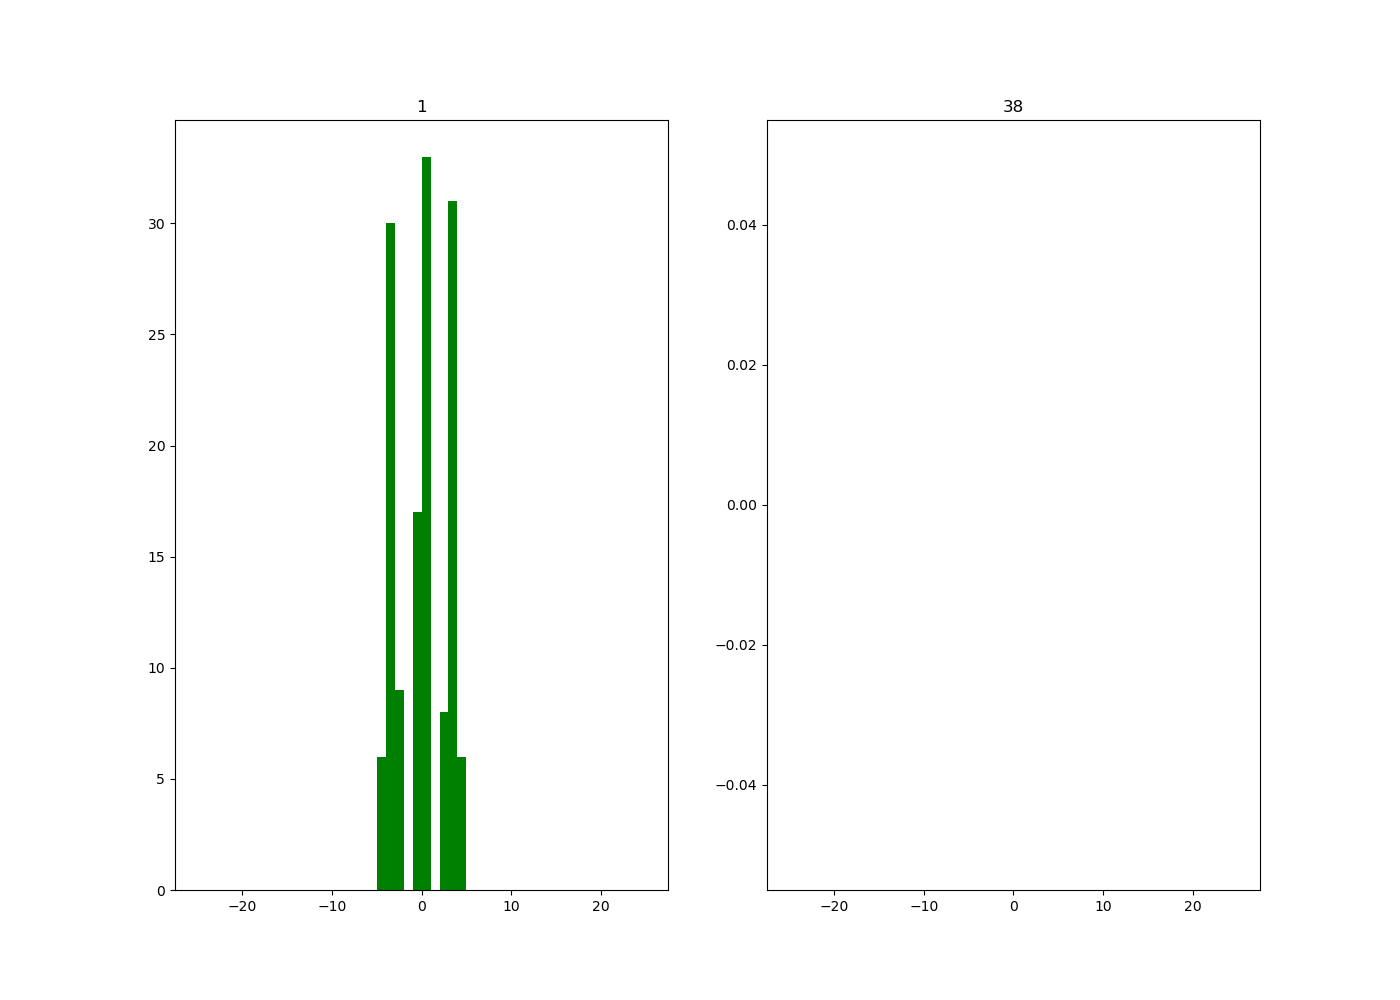

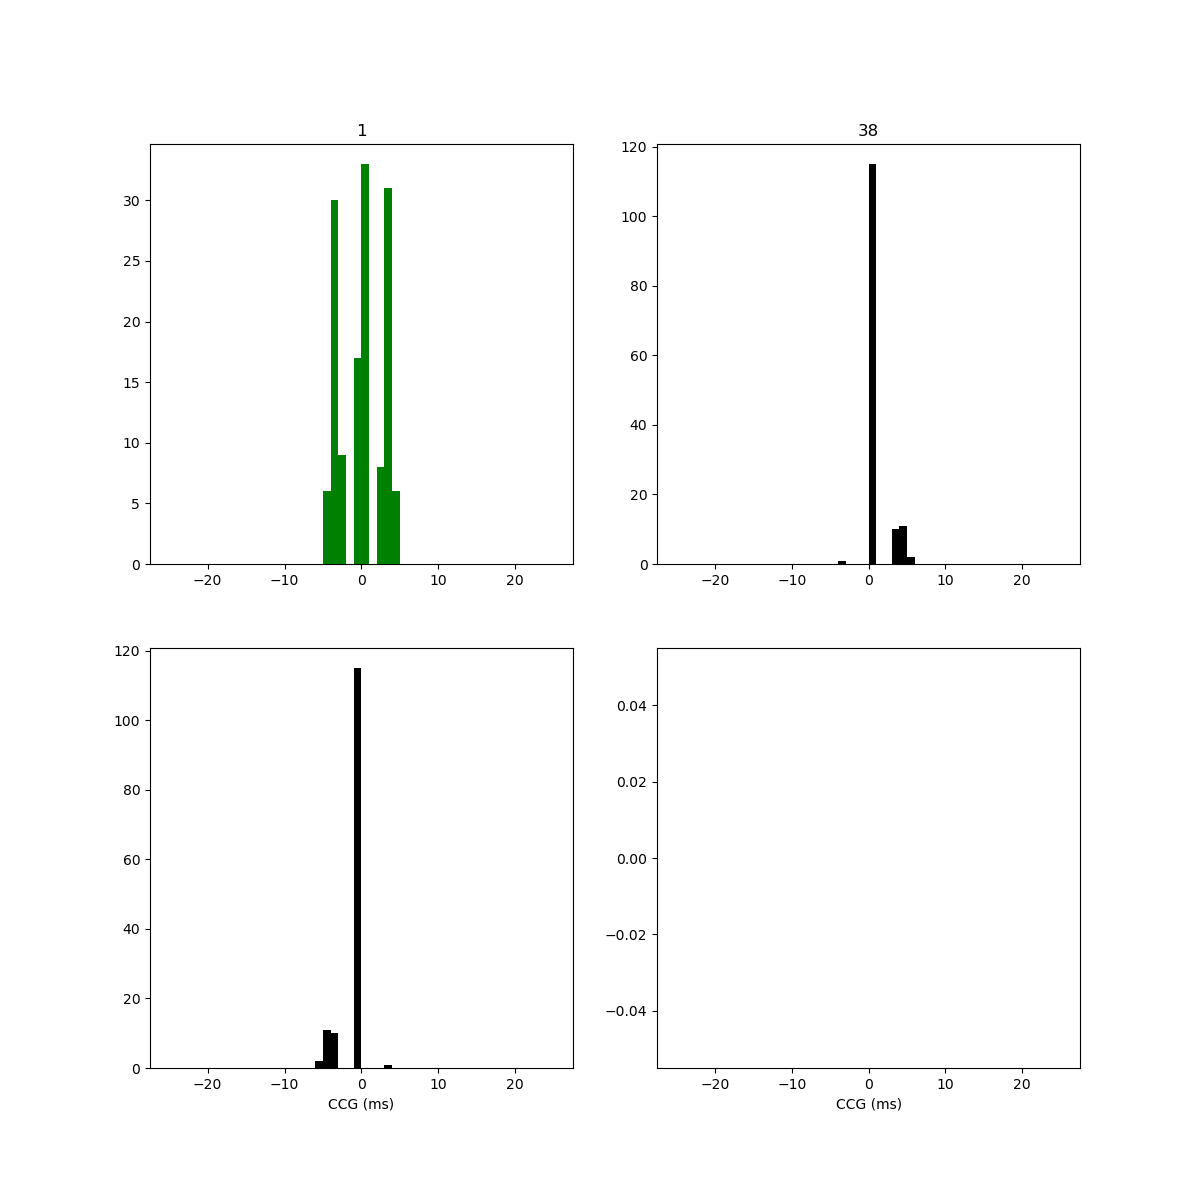

In [49]:
si.plot_autocorrelograms(we, unit_ids=sorting.unit_ids[::34], figsize=(14, 10))
si.plot_crosscorrelograms(we, unit_ids=sorting.unit_ids[::34], figsize=(12, 12))

### Compute template similarity

In [50]:
similarity = si.compute_template_similarity(we)

### Compute template metrics

Template metrics, or extracellular features, such as peak to valley duration or full-width half maximum, are important to classify neurons into putative classes (excitatory - inhibitory). The `postprocessing` allows one to compute several of these metrics:

In [51]:
print(si.get_template_metric_names())

['peak_to_valley', 'peak_trough_ratio', 'half_width', 'repolarization_slope', 'recovery_slope', 'num_positive_peaks', 'num_negative_peaks', 'velocity_above', 'velocity_below', 'exp_decay', 'spread']


In [52]:
template_metrics = si.compute_template_metrics(we)
display(template_metrics)

,half_width,num_negative_peaks,num_positive_peaks,peak_to_valley,peak_trough_ratio,recovery_slope,repolarization_slope
1,0.00021,2,3,0.00077,-0.326795,-1094392.553708,6087694.749838
2,0.0002,2,3,0.000773,-0.2675,-899879.293292,6182870.587179
3,0.00021,2,2,0.00074,-0.271467,-996021.089118,6997044.195243
4,0.00021,2,2,0.000737,-0.272008,-1045332.037271,7375348.306528
5,0.000203,2,2,0.000753,-0.256773,-820263.627239,6412711.268714
7,0.000193,2,3,0.000697,-0.298268,-975931.575183,7001089.451964
8,0.000063,0,0,0.000097,-1.830344,-315026.004171,8236386.378495
9,0.00009,3,3,0.000127,-0.675711,-48194.873393,3668196.879581
10,0.000213,2,2,0.000763,-0.28619,-997302.608755,6718747.972055
11,0.000207,2,5,0.000627,-0.355446,-628113.538681,3903277.882555


In [53]:
si.plot_template_metrics(we, include_metrics=["peak_to_valley", "half_width"], 
                         backend="ipywidgets")

AppLayout(children=(UnitSelector(children=(Label(value='Units', layout=Layout(justify_content='center')), Sele…

For more information about these template metrics, we refer to this [documentation](https://github.com/AllenInstitute/ecephys_spike_sorting/tree/master/ecephys_spike_sorting/modules/mean_waveforms) from the Allen Institute.

# 7. Quality metrics and curation <a class="anchor" id="curation"></a>

The `qualitymetrics` module also provides several functions to compute qualitity metrics to validate the spike sorting results.

See also this : https://spikeinterface.readthedocs.io/en/latest/modules/qualitymetrics.html

Let's see what metrics are available:

In [54]:
print(si.get_quality_metric_list())
print(si.get_quality_pca_metric_list())

['num_spikes', 'firing_rate', 'presence_ratio', 'snr', 'isi_violation', 'rp_violation', 'sliding_rp_violation', 'amplitude_cutoff', 'amplitude_median', 'amplitude_cv', 'synchrony', 'firing_range', 'drift', 'sd_ratio']
['isolation_distance', 'l_ratio', 'd_prime', 'nearest_neighbor', 'nn_isolation', 'nn_noise_overlap', 'silhouette']


In [55]:
qm_params = si.get_default_qm_params()
qm_params

{'presence_ratio': {'bin_duration_s': 60, 'mean_fr_ratio_thresh': 0.0},
 'snr': {'peak_sign': 'neg',
  'peak_mode': 'extremum',
  'random_chunk_kwargs_dict': None},
 'isi_violation': {'isi_threshold_ms': 1.5, 'min_isi_ms': 0},
 'rp_violation': {'refractory_period_ms': 1.0, 'censored_period_ms': 0.0},
 'sliding_rp_violation': {'min_spikes': 0,
  'bin_size_ms': 0.25,
  'window_size_s': 1,
  'exclude_ref_period_below_ms': 0.5,
  'max_ref_period_ms': 10,
  'contamination_values': None},
 'synchrony': {'synchrony_sizes': (2, 4, 8)},
 'firing_range': {'bin_size_s': 5, 'percentiles': (5, 95)},
 'amplitude_cv': {'average_num_spikes_per_bin': 50,
  'percentiles': (5, 95),
  'min_num_bins': 10,
  'amplitude_extension': 'spike_amplitudes'},
 'amplitude_cutoff': {'peak_sign': 'neg',
  'num_histogram_bins': 100,
  'histogram_smoothing_value': 3,
  'amplitudes_bins_min_ratio': 5},
 'amplitude_median': {'peak_sign': 'neg'},
 'drift': {'interval_s': 60,
  'min_spikes_per_interval': 100,
  'direction':

In [56]:
qm_params['isi_violation']['isi_threshold_ms'] = 1.1

In [65]:
metric_names = si.get_quality_metric_list()
# metric_names = si.get_quality_metric_list() + si.get_quality_pca_metric_list()
qm = si.compute_quality_metrics(we, metric_names=metric_names, verbose=True,  qm_params=qm_params, **job_kwargs)

Computing amplitude_cutoff
Computing amplitude_cv
Computing amplitude_median
Computing drift
Computing firing_range
Computing firing_rate
Computing isi_violation
Computing num_spikes
Computing presence_ratio
Computing rp_violation
Computing sd_ratio


ValueError: This recording does not support return_scaled=True (need gain_to_uV and offset_to_uV properties)

In [115]:
display(qm)

,num_spikes,firing_rate,presence_ratio,snr,isi_violations_ratio,isi_violations_count,rp_contamination,rp_violations,sliding_rp_violation,amplitude_cutoff,amplitude_median,amplitude_cv_median,amplitude_cv_range,sync_spike_2,sync_spike_4,sync_spike_8,firing_range,drift_ptp,drift_std,drift_mad
0,3467.0,11.556667,1.0,6.699185,0.907572,80,1.000000,81,NaN,0.000365,32.174999,0.371593,0.299797,0.030862,0.0,0.0,5.63,0.301125,0.110323,0.094155
1,945.0,3.150000,1.0,15.370731,0.152699,1,0.185099,1,NaN,0.009748,94.574997,0.178557,0.126878,0.024339,0.0,0.0,3.01,0.615780,0.218826,0.162426
2,805.0,2.683333,1.0,8.187921,0.631289,3,0.727769,2,NaN,0.003454,50.309998,0.304148,0.229177,0.034783,0.0,0.0,3.01,1.708486,0.613580,0.493461
3,1042.0,3.473333,1.0,16.009048,0.753554,6,1.000000,6,NaN,0.001854,81.899994,0.264475,0.105284,0.051823,0.0,0.0,2.22,0.938872,0.329965,0.208018
4,3051.0,10.170000,1.0,20.417950,0.512722,35,1.000000,33,NaN,0.000446,119.339996,0.133316,0.064901,0.035398,0.0,0.0,4.60,0.528079,0.190110,0.156396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,478.0,1.593333,1.0,13.007952,0.596819,1,1.000000,1,NaN,NaN,79.364998,NaN,NaN,0.039749,0.0,0.0,1.60,NaN,NaN,NaN
167,743.0,2.476667,1.0,8.902170,0.000000,0,0.000000,0,0.195,0.000647,53.624996,0.236704,0.092628,0.029610,0.0,0.0,1.62,0.740657,0.285873,0.264649
168,1179.0,3.930000,1.0,5.772798,0.196201,2,0.246105,2,NaN,0.001396,35.489998,0.396619,0.173722,0.036472,0.0,0.0,5.42,0.859374,0.292842,0.193800
169,1061.0,3.536667,1.0,8.605642,1.090210,9,1.000000,9,NaN,0.001560,46.994999,0.274625,0.210853,0.086711,0.0,0.0,2.62,1.301045,0.526499,0.474456


In [64]:
si.plot_quality_metrics(we, include_metrics=["amplitude_cutoff", "presence_ratio", "isi_violations_ratio", "snr"], 
                        backend="ipywidgets")

KeyError: 'metrics'

For more information about these waveform features, we refer to the [SpikeInterface documentation](https://spikeinterface.readthedocs.io/en/latest/module_qualitymetrics.html) and to this excellent [documentation](https://allensdk.readthedocs.io/en/latest/_static/examples/nb/ecephys_quality_metrics.html) from the Allen Institute.

## Automatic curation based on quality metrics

A viable option to curate (or at least pre-curate) a spike sorting output is to filter units based on quality metrics. As we have already computed quality metrics a few lines above, we can simply filter the `qm` dataframe based on some thresholds.

Here, we'll only keep units with an ISI violation threshold and amplitude cutoff below a user-defined threshold:

In [61]:
isi_viol_thresh = 0.5
amp_cutoff_thresh = 0.1

A straightforward way to filter a pandas dataframe is via the `query`.
We first define our query (make sure the names match the column names of the dataframe):

In [62]:
our_query = f"amplitude_cutoff < {amp_cutoff_thresh} & isi_violations_ratio < {isi_viol_thresh}"
print(our_query)

amplitude_cutoff < 0.1 & isi_violations_ratio < 0.5


and then we can use the query to select units:

In [63]:
keep_units = qm.query(our_query)
keep_unit_ids = keep_units.index.values
keep_unit_ids

NameError: name 'qm' is not defined

In [120]:
sorting_auto_KS25 = sorting.select_units(keep_unit_ids)
print(f"Number of units before curation: {len(sorting.get_unit_ids())}")
print(f"Number of units after curation: {len(sorting_auto_KS25.get_unit_ids())}")

Number of units before curation: 170
Number of units after curation: 33


We can also save all the waveforms and post-processed data for curated units in a separate folder:

In [121]:
we_curated = we.select_units(keep_unit_ids, new_folder=base_folder / "waveforms_curated")

In [122]:
print(we_curated)

WaveformExtractor: 47 channels - 33 units - 1 segments
  before:30 after:60 n_per_units:500 - sparse


In [123]:
%matplotlib widget
si.plot_unit_templates(we_curated, backend='ipywidgets')

AppLayout(children=(HBox(children=(Checkbox(value=False, description='same axis'), Checkbox(value=True, descri…

In [58]:
we_curated.get_available_extension_names()

NameError: name 'we_curated' is not defined

# 8. Viewers <a class="anchor" id="viewers"></a>


### SpikeInterface GUI

A QT-based GUI built on top of SpikeInterface objects.

Developed by Samuel Garcia, CRNL, Lyon.

In [135]:
# !sigui {base_folder}/waveforms_sparse

### Sorting Summary - SortingView

The `sortingview` backend requires an additional step to configure the transfer of the data to be plotted to the cloud. 

See documentation [here](https://spikeinterface.readthedocs.io/en/latest/module_widgets.html).

Developed by Jeremy Magland and Jeff Soules, Flatiron Institute, NYC

In [127]:
w = si.plot_sorting_summary(we_curated, backend="sortingview")

https://figurl.org/f?v=gs://figurl/spikesortingview-10&d=sha1://2a2cc53d21a7677c130fda6436c5839184f3e974

`sortingview` can also be used for manual curation and labeling of units!

In [136]:
# w = si.plot_sorting_summary(we_curated, backend="sortingview", curation=True)

https://figurl.org/f?v=gs://figurl/spikesortingview-10&d=sha1://61648243fcfd694dd6b179bc85626db03675a36f

You can apply the `sortingview` curation file with:

`sorting_manual_curated = si.apply_sortingview_curation(we_curated.sorting, uri_or_json="curation.json")`

# 9. Spike sorting comparison <a class="anchor" id="comparison"></a>

Can we combine the output of multiple sorters to curate the spike sorting output?

To answer this question we can use the `comparison` module.
We first compare and match the output spike trains of the different sorters, and we can then extract a new `Sorting` with only the units in agreement.

In [125]:
sorting_KS25 = si.read_sorter_folder(base_folder/"results_KS25")
sorting_KS2 = si.read_sorter_folder(base_folder/"results_KS2")

### Compare two sorters

In [126]:
comp_KS2_KS25 = si.compare_two_sorters(sorting_KS2, sorting_KS25, 'KS2', 'KS25')

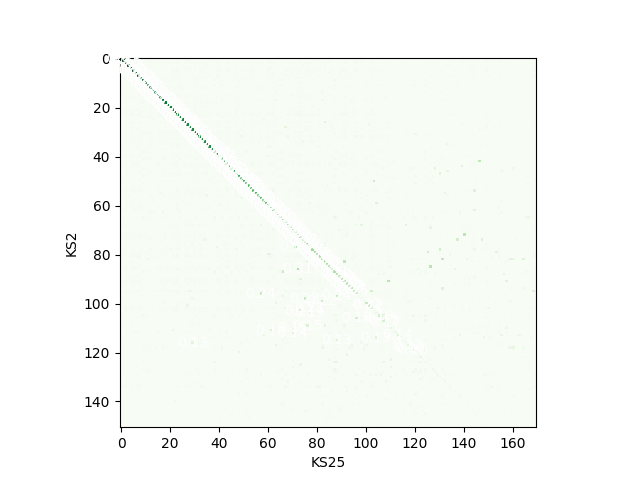

In [127]:
si.plot_agreement_matrix(comp_KS2_KS25, unit_ticks=False)

In [128]:
comp_KS2_KS25auto = si.compare_two_sorters(sorting_KS2, sorting_auto_KS25, 'KS2', 'KS25_auto')

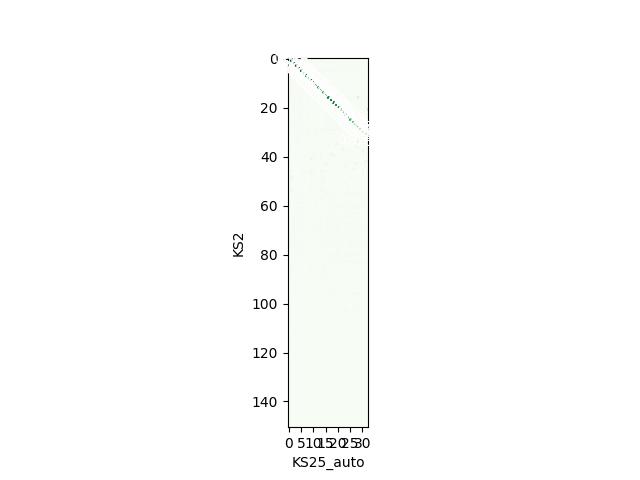

In [129]:
si.plot_agreement_matrix(comp_KS2_KS25auto, unit_ticks=False)

### Compare multiple sorters

In 2020, the spike interface team publish an article to demonstrate that sorters do not agree on the results.
See this https://elifesciences.org/articles/61834

Here is a direct illustration of the phenomenom on this dataset.

In [130]:
mcmp = si.compare_multiple_sorters([sorting_KS2, sorting_KS25], ['KS2', 'KS25'], 
                                   spiketrain_mode='union', verbose=True)

Multicomaprison step 1: pairwise comparison
  Comparing: KS2 and KS25
Multicomparison step 2: make graph
Multicomaprison step 3: clean graph
Removed 0 duplicate nodes
Multicomparison step 4: extract agreement from graph


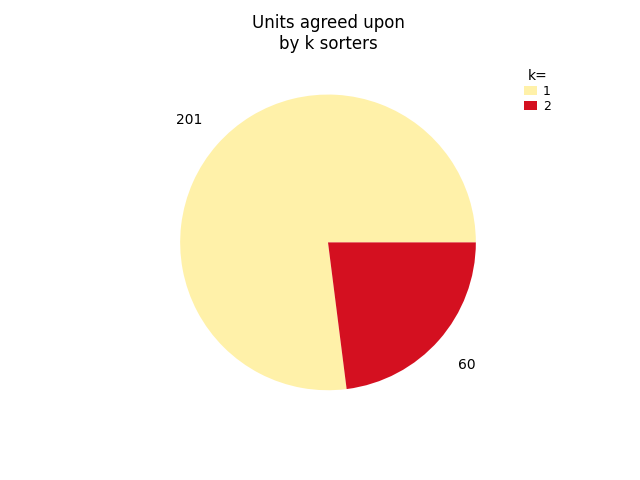

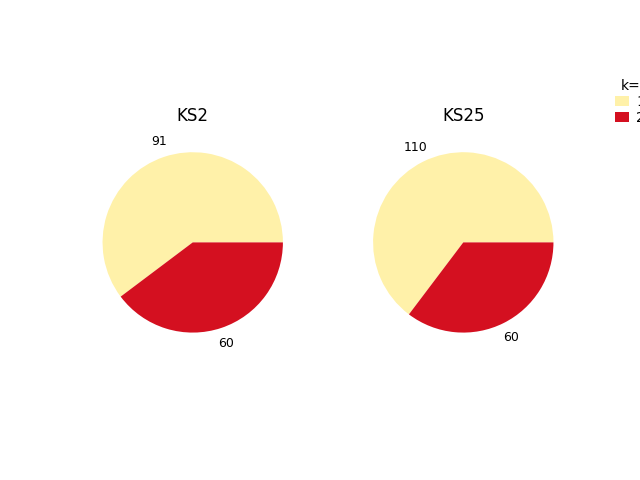

In [131]:
w = si.plot_multicomparison_agreement(mcmp)
w = si.plot_multicomparison_agreement_by_sorter(mcmp)

In [132]:
agreement_sorting = mcmp.get_agreement_sorting(minimum_agreement_count=2)
print(agreement_sorting)

AgreementSortingExtractor: 60 units - 1 segments - 30.0kHz


# 10. Exporters <a class="anchor" id="exporters"></a>

## Export to Phy for manual curation

To perform manual curation we can export the data to [Phy](https://github.com/cortex-lab/phy). 

In [66]:
si.export_to_phy(we, output_folder=base_folder / 'phy_KS3', 
                 compute_amplitudes=True, compute_pc_features=True, copy_binary=False,remove_if_exists=True,
                 **job_kwargs)

extract PCs:   0%|          | 0/1800 [00:00<?, ?it/s]

KeyError: 'metrics'

In [103]:
oe_folder

WindowsPath('C:/Users/neuroPC/Documents/Open Ephys/2024-02-01_18-55-51')

![phy](./phy.png)

After curating the results we can reload it using the `PhySortingExtractor` and exclude the units that we labeled as `noise`:

`sorting_phy_curated = si.read_phy(base_folder / 'phy_KS25/', exclude_cluster_groups=['noise'])`

## Export a report to a folder



In [ ]:
si.export_report(we, output_folder=base_folder / 'report_KS25')

### Et voilà!